In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data

Welcome to JupyROOT 6.18/04


### Call calibration class

In [2]:
t = pc.tpc_calibration()

### Load data

In [3]:
recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)

### Add new length metrics to test

In [4]:
def length_comparison(df, i):
    x = df['x'].iloc[i]
    y = df['y'].iloc[i]
    z = df['z'].iloc[i]
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis = 0)
    uu, dd, vv = np.linalg.svd(data-datamean)
    xhat = TVector3(vv[0][0],vv[0][1],vv[0][2])
    zhat = TVector3(0,0,1)
    yhat = zhat.Cross(xhat).Unit()
    yhat = np.array([yhat.x(), yhat.y(), yhat.z()])
    x_rel = x-x.mean()
    y_rel = y-y.mean()
    z_rel = z-z.mean()
    x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(x))],[vv[0][0],vv[0][1],vv[0][2]])
    y_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(y))],yhat)
        #y_track = np.array([TVector3(x_rel[i],y_rel[i],z_rel[i])*yhat for i in range(0,len(y))])
    #data = np.concatenate((x_track[:, np.newaxis], y_track[:, np.newaxis], z[:, np.newaxis]), axis=1)
    length_max = (x_track.max() - x_track.min())
    width_max = (y_track.max() - y_track.min())
    clength_max = np.sqrt(length_max**2+width_max**2)
    length_rms = 1/np.sqrt(len(x_track))*np.sqrt(np.sum(x_track**2))
    width_rms = 1/np.sqrt(len(y_track))*np.sqrt(np.sum(y_track**2))
    clength_rms = np.sqrt(length_rms**2 + width_rms**2)
    return length_max, clength_max, clength_rms

tpcs = recoils.keys()


for tpc in tpcs:
    cl_max = []
    cl_rms = []
    for i in range(0,len(recoils[tpc])):
        length, clength_max, clength_rms = length_comparison(recoils[tpc], i)
        cl_max.append(clength_max)
        cl_rms.append(clength_rms)
    recoils[tpc]['clength_max'] = cl_max
    recoils[tpc]['clength_rms'] = cl_rms

In [17]:
recoils['tako']['clength_max'] = np.sqrt(recoils['tako']['length']**2+5000**2)

### Validating length metrics (only run when doing so)

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
def plot(df, i):
    x = df.loc[df['track_energy'] > 20]['x'].iloc[i]
    y = df.loc[df['track_energy'] > 20]['y'].iloc[i]
    z = df.loc[df['track_energy'] > 20]['z'].iloc[i]
    c = df.loc[df['track_energy'] > 20]['tot'].iloc[i]
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis = 0)
    uu, dd, vv = np.linalg.svd(data-datamean)
    xhat = TVector3(vv[0][0],vv[0][1],vv[0][2])
    zhat = TVector3(0,0,1)
    yhat = zhat.Cross(xhat).Unit()
    yhat = np.array([yhat.x(), yhat.y(), yhat.z()])
    x_rel = x-x.mean()
    y_rel = y-y.mean()
    z_rel = z-z.mean()
    x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(x))],[vv[0][0],vv[0][1],vv[0][2]])
    y_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(y))],yhat)
        #y_track = np.array([TVector3(x_rel[i],y_rel[i],z_rel[i])*yhat for i in range(0,len(y))])
    #data = np.concatenate((x_track[:, np.newaxis], y_track[:, np.newaxis], z[:, np.newaxis]), axis=1)
    length = (x_track.max() - x_track.min())
    width = (y_track.max() - y_track.min())
    width2 = 1/np.sqrt(len(y_track))*np.sqrt(np.sum(y_track**2))
    length_rms = 1/np.sqrt(len(x_track))*np.sqrt(np.sum(x_track**2))
    width_rms = 1/np.sqrt(len(y_track))*np.sqrt(np.sum(y_track**2))
    #if width > length:
    #    clength = width
    #else:
    #    clength = np.abs(length-0.5*width)
    #clength = np.abs(length-width)
    clength = 1/np.sqrt(2*len(x_track))*np.sqrt(np.sum(x_track**2)+np.sum(y_track**2))
    clength2 = np.sqrt(length_rms**2 + width_rms**2)
    linepts = vv[0] * np.mgrid[-length/2:length/2:2j][:, np.newaxis]
    widthpts = yhat * np.mgrid[-width/2:width/2:2j][:, np.newaxis]
    clinepts = vv[0] * np.mgrid[-clength/2:clength/2:2j][:, np.newaxis]
    clinepts2 = vv[0] * np.mgrid[clength2/2:-clength2/2:2j][:, np.newaxis]
    linepts += datamean
    widthpts += datamean
    clinepts += datamean
    clinepts2 += datamean
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    p = ax.scatter3D(*data.T, c=c, cmap = 'viridis')
    ax.plot3D(*linepts.T, color = 'red', label = ' raw length')
    ax.plot3D(*widthpts.T, color = 'blue', label = 'width')
    ax.plot3D(*clinepts.T, color = 'magenta', label = 'corrected_length', linewidth=8)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_xlim(0,20000)
    #ax.set_ylim(0,18000)
    fig.colorbar(p, ax=ax, label = 'ToT')
    ax.legend()
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    p = ax1.scatter3D(*data.T, c=c, cmap = 'viridis')
    ax1.plot3D(*linepts.T, color = 'red', label = 'length')
    ax1.plot3D(*widthpts.T, color = 'blue', label = 'width')
    ax1.plot3D(*clinepts2.T, color = 'magenta', label = 'corrected_length', linewidth=8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    #ax1.set_xlim(0,20000)
    #ax1.set_ylim(0,18000)
    fig.colorbar(p, ax=ax1, label = 'ToT')
    ax.legend()
    fig.tight_layout()
    #print(length, clength, clength2)
    plt.show()
    print(df['theta'].iloc[i])
for i in range(0,6):
    plot(recoils['iiwi'], i)

### Visualize EvL for 4 TPCs with clean bands

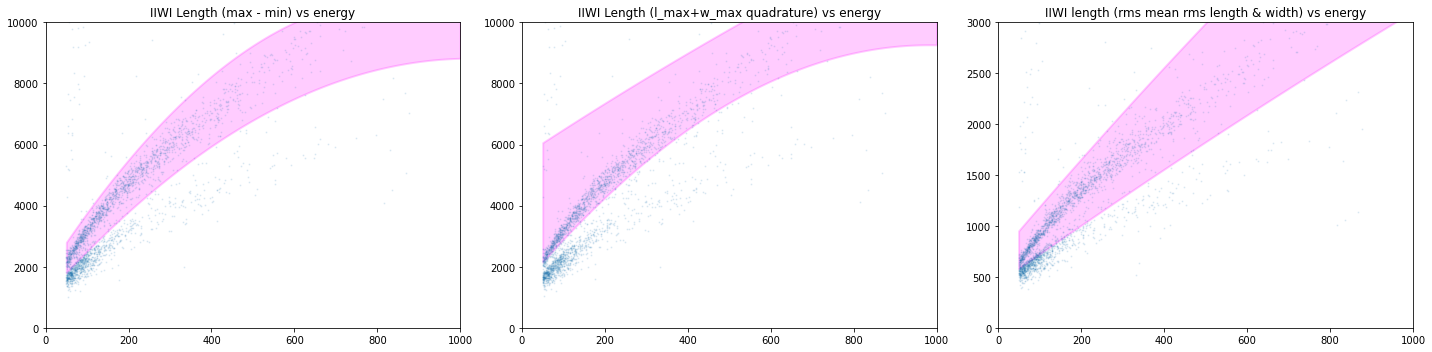

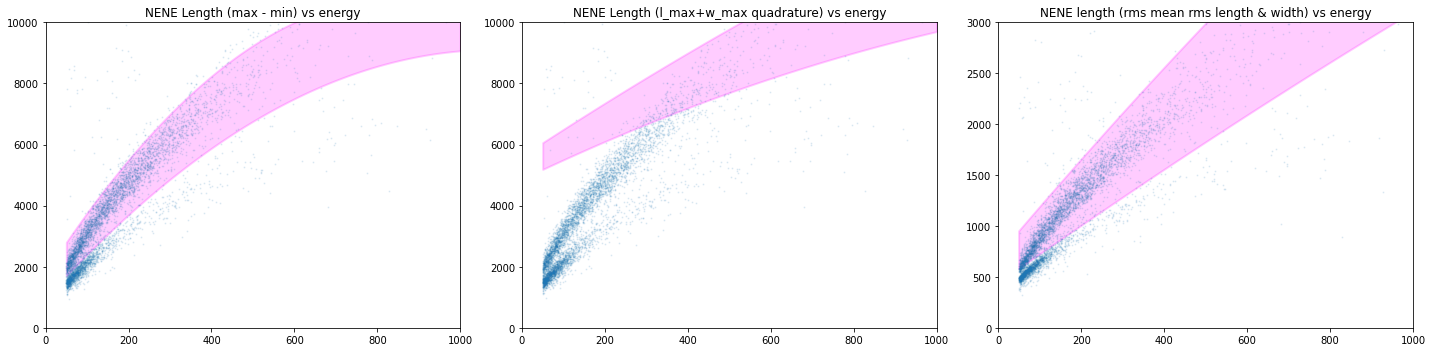

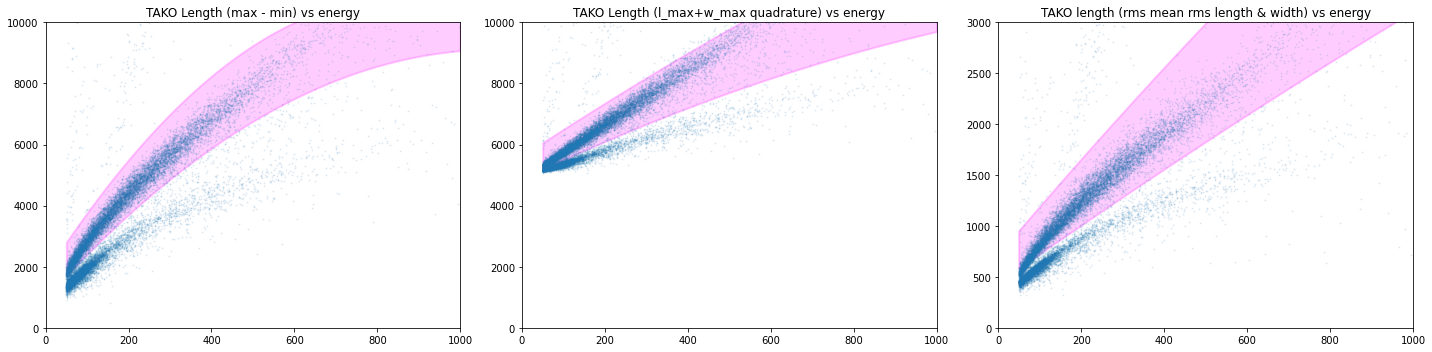

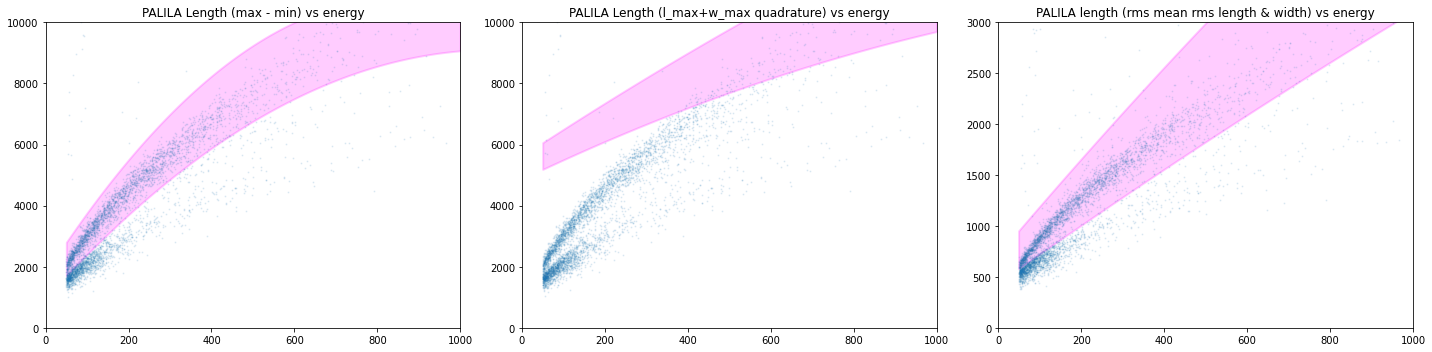

In [21]:
for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    fig = plt.figure(figsize = (20,5))
    plt.subplot(1,3,1)
    plt.plot(recoils[tpc]['full_corrected_energy'], recoils[tpc]['length'], 'o', markersize = 1, alpha = 0.1)
    plt.xlim(0,1000)
    plt.ylim(0,10000)
    x1 = np.array([50, 200, 600])
    if tpc == 'iiwi':
        y1_min = np.array([1800,3800,7500])
    else:
        y1_min = np.array([1700,3700,7500])
    p1_min = np.polyfit(x1,y1_min,2)
    y1_max = np.array([2800,5500,10000])
    p1_max = np.polyfit(x1,y1_max,2)
    x_plt = np.linspace(50,1000,951)
    plt.fill_between(x_plt, p1_min[0]*x_plt**2 + p1_min[1]*x_plt + p1_min[2], p1_max[0]*x_plt**2 + p1_max[1]*x_plt + p1_max[2], color = 'magenta', alpha = 0.2, linewidth = 2, edgecolor = 'magenta')
    plt.title('%s Length (max - min) vs energy'%(tpc.upper()))
    plt.subplot(1,3,2)
    x2 = np.array([100, 400, 800])
    if tpc == 'iiwi':
        y2_min = np.array([2900,6500,9000])
    else:
        y2_min = np.array([2840,6080,9000])
    p2_min = np.polyfit(x2,y2_min,2)
    y2_max = np.array([4000,8500,12000])
    p2_max = np.polyfit(x2,y2_max,2)
    plt.plot(recoils[tpc]['full_corrected_energy'], recoils[tpc]['clength_max'], 'o', markersize = 1, alpha = 0.1)
    plt.fill_between(x_plt, p2_min[0]*x_plt**2 + p2_min[1]*x_plt + p2_min[2], p2_max[0]*x_plt**2 + p2_max[1]*x_plt + p2_max[2], color = 'magenta', alpha = 0.2, linewidth = 2, edgecolor = 'magenta')
    plt.xlim(0,1000)
    plt.ylim(-.1,10000)
    plt.title('%s Length (l_max+w_max quadrature) vs energy'%(tpc.upper()))
    plt.subplot(1,3,3)
    plt.plot(recoils[tpc]['full_corrected_energy'], recoils[tpc]['clength_rms'], 'o', markersize = 1, alpha = 0.1)
    x3 = np.array([200, 400, 1000])
    y3_min = np.array([1000,1550,3100])
    p3_min = np.polyfit(x3,y3_min,2)
    y3_max = np.array([1650,2550,5000])
    p3_max = np.polyfit(x3,y3_max,2)
    plt.fill_between(x_plt, p3_min[0]*x_plt**2 + p3_min[1]*x_plt + p3_min[2], p3_max[0]*x_plt**2 + p3_max[1]*x_plt + p3_max[2], color = 'magenta', alpha = 0.2, linewidth = 2, edgecolor = 'magenta')
    plt.xlim(0,1000)
    plt.ylim(0,3000)
    plt.title('%s length (rms mean rms length & width) vs energy'%(tpc.upper()))
    plt.tight_layout()
    plt.show()

In [22]:
p1_min, p1_max, p2_min, p2_max, p3_min, p3_max

(array([-6.96969697e-03,  1.50757576e+01,  9.63636364e+02]),
 array([-1.22727273e-02,  2.10681818e+01,  1.77727273e+03]),
 array([-1.66666667e-03,  6.50000000e+00,  4.86666667e+03]),
 array([-1.19047619e-03,  8.92857143e+00,  5.61904762e+03]),
 array([-2.08333333e-04,  2.87500000e+00,  4.33333333e+02]),
 array([-5.20833333e-04,  4.81250000e+00,  7.08333333e+02]))

### Apply He recoil band preliminary cuts (to train double gaussian fitter)

In [23]:
def apply_He_band_cuts(df, tpc, lcor = 0): #Cuts to train double Gaussian fit
    if lcor == 0:
        if tpc == 'iiwi':
            cut_min = np.array([-7.42424242e-03,  1.51893939e+01,  1.05909091e+03])
        else:
            cut_min = np.array([-6.96969697e-03,  1.50757576e+01,  9.63636364e+02])
        cut_max = np.array([-1.22727273e-02,  2.10681818e+01,  1.77727273e+03])
        lkey = 'length'
    elif lcor == 1:
        if tpc == 'iiwi':
            cut_min = np.array([-8.21428571e-03,  1.61071429e+01,  1.37142857e+03])
        else:
            cut_min = np.array([-5.00e-03,  1.33e+01,  1.56e+03])
        cut_max = np.array([-8.92857143e-03,  1.94642857e+01,  2.14285714e+03])
        lkey = 'clength_max'
    elif lcor == 2:
        cut_min = np.array([-2.08333333e-04,  2.87500000e+00,  4.33333333e+02])
        cut_max = np.array([-5.20833333e-04,  4.81250000e+00,  7.08333333e+02])
        lkey = 'clength_rms'
    ekey = 'full_corrected_energy'
    df = df.loc[df[ekey]>50]
    df_red = df.loc[(df[lkey] > (cut_min[0]*df[ekey]**2 + cut_min[1]*df[ekey]+cut_min[2])) & (df[lkey] < (cut_max[0]*df[ekey]**2 + cut_max[1]*df[ekey]+cut_max[2]))]
    return df, df_red

recoils_red_raw = {}
recoils_red_corrected_max = {}
recoils_red_corrected_rms = {}
tpcs = recoils.keys()
for tpc in tpcs:
    recoils[tpc], recoils_red_raw[tpc] = apply_He_band_cuts(recoils[tpc], tpc, lcor = 0)
    recoils[tpc], recoils_red_corrected_max[tpc] = apply_He_band_cuts(recoils[tpc], tpc, lcor = 1)
    recoils[tpc], recoils_red_corrected_rms[tpc] = apply_He_band_cuts(recoils[tpc], tpc, lcor = 2)

### Plot histograms at various length slices and fit double gaussians to get energy resolution of bands

In [ ]:
def plot_histogram(tpc, tpc_red, slice, width, bins, lcor = 0):
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'clength_max'
    elif lcor == 2:
        lkey = 'clength_rms'
    ekey = 'full_corrected_energy'
    fig = plt.figure(figsize = (8,6))
    index = tpc.loc[(tpc[ekey] < (slice + width)) & (tpc[ekey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[ekey] < (slice + width)) & (tpc_red[ekey] > (slice - width))].index.to_numpy()
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    data = tpc_red[lkey][index_red] #only He recoils
    full_data = tpc[lkey][index] #all recoils
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    #plt.legend()
    #plt.xlabel('Recoil Energy [keV]')
    plt.subplot(2,1,1)
    if (lcor == 0) or (lcor == 1):
        x_plt = np.linspace(0,10000,10001)
        y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,10000))
    else:
        x_plt = np.linspace(0,3000,3001)
        y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,3000))
    x_full=(x_full[1:]+x_full[:-1])/2
    CO = full_data.loc[full_data.index.isin(index_red) == False]
    expected_full=(np.mean(data),np.std(data),len(data), np.mean(CO), np.std(CO), len(full_data)-len(data))
    try:
        params_full,cov_full=curve_fit(bimodal,x_full,y_full, expected_full)
        plt.plot(x_plt,bimodal(x_plt,*params_full),color='red',lw=3,label='fit')
        plt.legend()
        plt.xlabel('Length [um]')
        sigma_full=sqrt(diag(cov_full))
        plt.title('Recoil Energy: %s < length < %s' %(int(slice - width), int(slice+width)))
        #plt.subplot(2,1,2)
        #plt.plot(tpc[ekey], tpc[lkey], 'o', markersize = 0.5, alpha = 0.5)
        #plt.plot(tpc[ekey][index], tpc[lkey][index], 'o', markersize = 0.5)
        #if (lcor == 0) or (lcor == 1):
        #    plt.ylim(0,10000)
        #else:
        #    plt.ylim(0,3000)
        #plt.xlim(0,800)
        #plt.xlabel('Recoil Energy [keV]')
        #plt.ylabel('Track length [um]')
        #plt.tight_layout()
        #print(params_full,'\n',sigma_full)
        He_reso = params_full[1]/params_full[0]
        He_reso_err = He_reso*np.sqrt((sigma_full[1]/params_full[1])**2+(sigma_full[0]/params_full[0])**2)
        CO_reso = params_full[4]/params_full[3]
        CO_reso_err = CO_reso*np.sqrt((sigma_full[4]/params_full[4])**2+(sigma_full[3]/params_full[3])**2)
        #print('He recoil resolution: %s +/- %s'%(He_reso, He_reso_err))
        #print('CO recoil resolution: %s +/- %s'%(CO_reso, CO_reso_err))
        energy = tpc[ekey][index].mean()
        energy_err = tpc[ekey][index].std()/np.sqrt(len(index))
        #print('length = %s +/- %s'%(length, length_err))
        #print(params_full)
    except RuntimeError:
        energy, energy_err, He_reso, He_reso_err, CO_reso, CO_reso_err = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        pass
'''
for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    he_slices = [10*i + 100 for i in range(0,50)]
    he_width = [5 for i in range(0,50)]
    for i in range(0,len(he_slices)):
        plot_histogram(recoils[tpc], recoils_red_raw[tpc], he_slices[i], he_width[i], bins=100, lcor = 0)
        plt.savefig('%s_case1_%s_slice_um.png'%(tpc, he_slices[i]))
        plt.clf()
        plot_histogram(recoils[tpc], recoils_red_corrected_max[tpc], he_slices[i], he_width[i], bins=100, lcor = 1)
        plt.savefig('%s_case2_%s_slice_um.png'%(tpc, he_slices[i]))
        plt.clf()
        #plot_histogram(recoils[tpc], recoils_red_corrected_rms[tpc], he_slices[i], he_width[i], bins=100, lcor = 2)
        #plt.savefig('%s_case3_%s_slice_um.png'%(tpc, he_slices[i]))
        #plt.clf()
'''
plot_histogram(recoils['tako'], recoils_red_raw['tako'], 150, 5, 100, lcor = 0)
plot_histogram(recoils['tako'], recoils_red_corrected_max['tako'], 150, 5, 100, lcor = 1)

### Extract energy resolutions

In [26]:
def get_fit_parameters(tpc, tpc_red, slice, width, bins, lcor = 0):
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'clength_max'
    elif lcor == 2:
        lkey = 'clength_rms'
    ekey = 'full_corrected_energy'
    index = tpc.loc[(tpc[ekey] < (slice + width)) & (tpc[ekey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[ekey] < (slice + width)) & (tpc_red[ekey] > (slice - width))].index.to_numpy()
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    data = tpc_red[lkey][index_red] #only He recoils
    full_data = tpc[lkey][index] #all recoils
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    if (lcor == 0) or (lcor == 1):
        x_plt = np.linspace(0,10000,10001)
        y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,10000))
    else:
        x_plt = np.linspace(0,3000,3001)
        y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,3000))
    x_full=(x_full[1:]+x_full[:-1])/2
    CO = full_data.loc[full_data.index.isin(index_red) == False]
    expected_full=(np.mean(data),np.std(data),len(data), np.mean(CO), np.std(CO), len(full_data)-len(data))
    try:
        params_full,cov_full=curve_fit(bimodal,x_full,y_full, expected_full)
        sigma_full=sqrt(diag(cov_full))
        #print(params_full,'\n',sigma_full)
        #if len(full_data) < 40:
        #    He_reso = np.nan
        #    He_reso_err = np.nan
        #else:
        He_reso = params_full[1]/params_full[0]
        He_reso_err = He_reso*np.sqrt((sigma_full[1]/params_full[1])**2+(sigma_full[0]/params_full[0])**2)
        CO_reso = params_full[4]/params_full[3]
        CO_reso_err = CO_reso*np.sqrt((sigma_full[4]/params_full[4])**2+(sigma_full[3]/params_full[3])**2)
        energy = tpc[ekey][index].mean()
        energy_err = tpc[ekey][index].std()/np.sqrt(len(index))
        plt.clf()
    except RuntimeError:
        energy, energy_err, He_reso, He_reso_err, CO_reso, CO_reso_err = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    return energy, energy_err, He_reso, He_reso_err, CO_reso, CO_reso_err
    
def make_dataframes(df, df_red, slices = [2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400], widths = [25, 25, 50, 50, 50, 50, 50, 50], bins = 60, lcor = 0):
    #tpcs = ['iiwi', 'nene', 'tako', 'palila']
    tpcs = ['tako']
    e = {}
    de = {}
    He_res = {}
    He_res_err = {}
    CO_res = {}
    CO_res_err = {}
    for tpc in tpcs:
        e[tpc], de[tpc], He_res[tpc], He_res_err[tpc], CO_res[tpc], CO_res_err[tpc] = [], [], [], [], [], []
        for i in range(0,len(slices)):
            energy, energy_err, He_reso, He_reso_err, CO_reso, CO_reso_err = get_fit_parameters(df[tpc], df_red[tpc], slices[i], widths[i], bins, lcor)
            if np.abs(He_reso_err) > 0.3*He_reso:
                He_reso = np.nan
                He_reso_err = np.nan
            if tpc == 'tako':
                if (energy > 437) and (energy < 453):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if energy >= 560:
                    He_reso = np.nan
                    He_reso_err = np.nan
                #if (energy > 337) and (energy < 343):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
                #if (energy > 367) and (energy < 373):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
                #if (energy > 397) and (energy < 403):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
                #if (energy > 397) and (energy < 403):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
                if (energy > 477) and (energy < 483):
                    He_reso = np.nan
                    He_reso_err = np.nan
                #if (energy > 497) and (energy < 513):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
                if (energy > 537) and (energy < 543):
                    He_reso = np.nan
                    He_reso_err = np.nan
                #if (energy > 557) and (energy < 563):
                #    He_reso = np.nan
                #    He_reso_err = np.nan
            '''    
            if tpc == 'nene':
                if energy >= 400:
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 137) and (energy < 143):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 227) and (energy < 233):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 337) and (energy < 343):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 357) and (energy < 363):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 377) and (energy < 383):
                    He_reso = np.nan
                    He_reso_err = np.nan
                    
            if tpc == 'iiwi':
                if energy >= 350:
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 97) and (energy < 113):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 137) and (energy < 143):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 187) and (energy < 213):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 237) and (energy < 243):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 257) and (energy < 263):
                    He_reso = np.nan
                    He_reso_err = np.nan
                    
            if tpc == 'palila':
                if energy >= 390:
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 97) and (energy < 103):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 237) and (energy < 253):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 277) and (energy < 283):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 307) and (energy < 323):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 337) and (energy < 343):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (energy > 357) and (energy < 363):
                    He_reso = np.nan
                    He_reso_err = np.nan
            '''
            e[tpc].append(energy)
            de[tpc].append(energy_err)
            He_res[tpc].append(He_reso)
            He_res_err[tpc].append(He_reso_err)
            CO_res[tpc].append(CO_reso)
            CO_res_err[tpc].append(CO_reso_err)
    e = pd.DataFrame.from_dict(e)
    de = pd.DataFrame.from_dict(de)
    He_res = pd.DataFrame.from_dict(He_res)
    He_res_err = pd.DataFrame.from_dict(He_res_err)
    CO_res = pd.DataFrame.from_dict(CO_res)
    CO_res_err = pd.DataFrame.from_dict(CO_res_err)
    return e, de, He_res, He_res_err, CO_res, CO_res_err

#he_slices = [10*i+90 for i in range(0,9)]
#he_widths = [5 for i in range(0,9)]
#bins = 100

#he_slices = [20*i + 100 for i in range(0,16)]
#he_widths = [10 for i in range(0,16)]
#bins = 50

he_slices = [6*i + 100 for i in range(1,50)]
he_widths = [3 for i in range(1,50)]
bins = 100

case1_e, case1_e_err, case1_He_res, case1_He_res_err, case1_CO_res, case1_CO_res_err = make_dataframes(recoils, recoils_red_raw, slices = he_slices, widths = he_widths, bins = 100, lcor = 0)
case2_e, case2_e_err, case2_He_res, case2_He_res_err, case2_CO_res, case2_CO_res_err = make_dataframes(recoils, recoils_red_corrected_max, slices = he_slices, widths = he_widths, bins = 100, lcor = 1)
case3_e, case3_e_err, case3_He_res, case3_He_res_err, case3_CO_res, case3_CO_res_err = make_dataframes(recoils, recoils_red_corrected_rms, slices = he_slices, widths = he_widths, bins = 100, lcor = 2)

<Figure size 432x288 with 0 Axes>

### Plot He recoil resolutions length

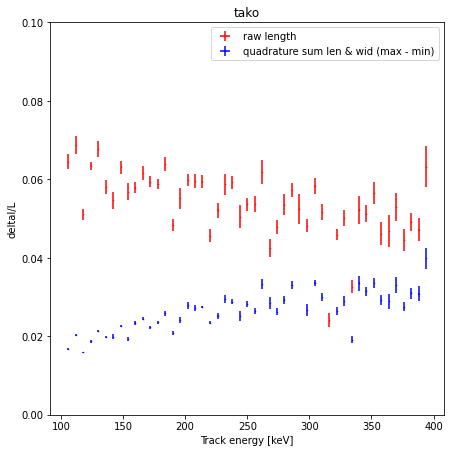

In [27]:
fig = plt.figure(figsize = (12,12))
i = 0
tpcs = [val for val in case1_e.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_e[tpc], np.abs(case1_He_res[tpc]), case1_He_res_err[tpc], case1_e_err[tpc], 'o', markersize = 0.5, label = 'raw length', color = 'red')
    plt.errorbar(case2_e[tpc], np.abs(case2_He_res[tpc]), case2_He_res_err[tpc], case2_e_err[tpc], 'o', markersize = 0.5, label = 'quadrature sum len & wid (max - min)', color = 'blue')
    #plt.errorbar(case3_e[tpc], np.abs(case3_He_res[tpc]), case3_He_res_err[tpc], case3_e_err[tpc], 'o', markersize = 0.5, label = 'quadrature sum len & wid (rms)', color = 'blue')
    plt.xlabel('Track energy [keV]')
    plt.ylabel('deltal/L')
    plt.title(tpc)
    plt.ylim(0,0.1)
    i+=1
    plt.legend(loc = 'upper right')
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize = (12,12))
i = 0
tpcs = [val for val in case1_e.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_e[tpc], np.abs(case1_He_res[tpc]), case1_He_res_err[tpc], case1_e_err[tpc], 'o', markersize = 2, label = 'raw length', color = 'red')
    #plt.errorbar(case2_e[tpc], np.abs(case2_He_res[tpc]), case2_He_res_err[tpc], case2_e_err[tpc], 'o', markersize = 0.5, label = 'rms length', color = 'cyan')
    #plt.errorbar(case3_e[tpc], np.abs(case3_He_res[tpc]), case3_He_res_err[tpc], case3_e_err[tpc], 'o', markersize = 0.5, label = 'len - width (max-min)', color = 'blue')
    #plt.errorbar(case4_e[tpc], np.abs(case4_He_res[tpc]), case4_He_res_err[tpc], case4_e_err[tpc], 'o', markersize = 2, label = 'len - width (rms)', color = 'black')
    plt.errorbar(case5_e[tpc], np.abs(case5_He_res[tpc]), case5_He_res_err[tpc], case5_e_err[tpc], 'o', markersize = 2, label = 'length + width (rms)', color = 'gold')
    plt.errorbar(case6_e[tpc], np.abs(case6_He_res[tpc]), case6_He_res_err[tpc], case6_e_err[tpc], 'o', markersize = 2, label = 'cor length rms sum (rms)', color = 'blue')
    #plt.errorbar(case7_e[tpc], np.abs(case7_He_res[tpc]), case7_He_res_err[tpc], case7_e_err[tpc], 'o', markersize = 2, label = 'fitter axis length - width', color = 'cyan')
    plt.xlabel('Track energy [keV]')
    plt.ylabel('deltal/L')
    plt.title(tpc)
    plt.ylim(0,0.1)
    plt.xlim(0,500)
    i+=1
    plt.legend(loc = 'upper right')
fig.tight_layout()
#plt.savefig('length_resolution_best.png')
plt.show()

### Plot C/O recoil resolutions

In [ ]:
fig = plt.figure(figsize = (12,12))
i = 0
tpcs = [val for val in case1_e.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_e[tpc], np.abs(case1_CO_res[tpc]), case1_CO_res_err[tpc], case1_e_err[tpc], 'o', markersize = 0.5, label = 'raw length', color = 'red')
    plt.errorbar(case2_e[tpc], np.abs(case2_CO_res[tpc]), case2_CO_res_err[tpc], case2_e_err[tpc], 'o', markersize = 0.5, label = 'rms length', color = 'cyan')
    plt.errorbar(case3_e[tpc], np.abs(case3_CO_res[tpc]), case3_CO_res_err[tpc], case3_e_err[tpc], 'o', markersize = 0.5, label = 'len - width (max-min)', color = 'blue')
    plt.errorbar(case4_e[tpc], np.abs(case4_CO_res[tpc]), case4_CO_res_err[tpc], case4_e_err[tpc], 'o', markersize = 0.5, label = 'len - width (rms)', color = 'black')
    plt.errorbar(case5_e[tpc], np.abs(case5_CO_res[tpc]), case5_CO_res_err[tpc], case5_e_err[tpc], 'o', markersize = 0.5, label = 'length + width (rms)', color = 'gold')
    plt.errorbar(case6_e[tpc], np.abs(case6_CO_res[tpc]), case6_CO_res_err[tpc], case6_e_err[tpc], 'o', markersize = 0.5, label = 'cor length rms sum (rms)', color = 'magenta')
    #plt.errorbar(case7_e[tpc], np.abs(case7_He_res[tpc]), case7_He_res_err[tpc], case7_e_err[tpc], 'o', markersize = 2, label = 'fitter axis length', color = 'indigo')
    plt.xlabel('Track energy [keV]')
    plt.ylabel('deltal/L')
    plt.title(tpc)
    plt.ylim(0,0.4)
    i+=1
    plt.legend(loc = 'upper right')
fig.tight_layout()
plt.show()

In [ ]:
cr['iiwi'].columns